<a href="https://colab.research.google.com/github/liliagrasso/progettiepubblicazioni/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing and installing libaries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install dash

In [ ]:
!pip install torch

In [ ]:
!pip install dash_bootstrap_components

In [ ]:
!pip install keybert

In [ ]:
!pip install transformers

In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
!pip install plotly==5.15.0

In [ ]:
!pip install pyLDAvis

In [ ]:
## for data
import json
import pandas as pd
import numpy as np
import tqdm

## for processing
import re
import nltk
import collections

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib import rcParams
!python -m spacy download en_core_web_sm
import spacy
from wordcloud import WordCloud, STOPWORDS
color = sns.color_palette()
%matplotlib inline
from plotly.offline import init_notebook_mode, iplot
import plotly.offline as py
import plotly.io as pio
pio.renderers.default = "colab"
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px


## for w2v
import gensim
import gensim.downloader as gensim_api

## for BERT
import transformers
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics, manifold

# string manipulation libs
import string

from nltk.corpus import stopwords, sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer             # ML library
from sklearn.decomposition import LatentDirichletAllocation
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer    # rule-based sentiment analysis tool



#nltk components
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords.extend(['work','product','use'])

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [ ]:
file = open('/content/drive/MyDrive/NLP Task/reviews.txt', encoding="utf8")
a= file.read()

In [ ]:
reviews=pd.read_csv('/content/drive/MyDrive/NLP Task/reviews.txt', delimiter= '\t', index_col=False, header=None, names=["reviews"])

In [ ]:
reviews.to_csv('reviews.csv', index=False)

In [ ]:
reviews.head()

,reviews
0,I needed a set of jumper cables for my new car...
1,"These long cables work fine for my truck, but ..."
2,Can't comment much on these since they have no...
3,I absolutley love Amazon!!! For the price of ...
4,I purchased the 12' feet long cable set and th...


## Preprocessing Reviews

In [ ]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    '''

    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()

    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
reviews["text_clean"] = reviews["reviews"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
reviews['len']=reviews['reviews'].apply(len)
reviews['word_count'] = reviews['reviews'].apply(lambda x: len(str(x).split()))
reviews.head()



,reviews,text_clean,len,word_count
0,I needed a set of jumper cables for my new car...,needed set jumper cable new car good review go...,516,101
1,"These long cables work fine for my truck, but ...",long cable fine truck quality seems little sha...,265,51
2,Can't comment much on these since they have no...,cant comment much since yet used come back upd...,1142,230
3,I absolutley love Amazon!!! For the price of ...,absolutley love amazon price set cheap booster...,4739,864
4,I purchased the 12' feet long cable set and th...,purchased 12 foot long cable set arrived retai...,415,77


## Sentiment Analysis

In [ ]:
def trim_length(text):
    '''
    This method removes the repeating characters that are repeated more than 2 times
    '''
    pat = re.compile(r"(.)\1{2,}")
    return pat.sub(r"\1\1", text)

def word_correct(myStr):
    '''
    This method accepts a string and removes the meta characters from it
    '''
    myStr = str(myStr)
    pat = re.compile(r'[^a-zA-Z1-9]+')
    corrected_str = ''
    splits = myStr.split()
    for word in splits:
        word = word.strip()
        word = re.sub(pat, '', word).lower()
        word = trim_length(word)
        corrected_str = corrected_str+word+' '
    corrected_str = corrected_str.strip()
    return corrected_str

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_word(myStr):
    myStr = str(myStr)
    lemmatizer = WordNetLemmatizer()
    lst_word = nltk.word_tokenize(myStr)
    final_str=''
    for word in lst_word:
        word = lemmatizer.lemmatize(word, get_pos(word))
        final_str = final_str+word+' '

    final_str = final_str.strip()
    return final_str



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
reviews['reviews'] = reviews['reviews'].apply(lambda i:word_correct(i))
reviews['reviews'] = reviews['reviews'].apply(lambda i: lemmatize_word(i))

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))

In [ ]:
scores =[]
sentences = list(reviews['reviews'])

for sentence in sentences:
    score = analyser.polarity_scores(sentence)
    scores.append(score)

#Converting List of Dictionaries into Dataframe
dataFrame= pd.DataFrame(scores)

print(dataFrame)

print("Overall Sentiment Score for the multiple sentences :- ",dataFrame.mean())

         neg    neu    pos  compound
0      0.019  0.883  0.097    0.7371
1      0.000  0.852  0.148    0.8095
2      0.087  0.799  0.114    0.8786
3      0.071  0.857  0.072   -0.9176
4      0.000  0.946  0.054    0.5106
...      ...    ...    ...       ...
20448  0.063  0.840  0.097    0.6597
20449  0.065  0.846  0.089    0.9547
20450  0.035  0.878  0.087    0.9428
20451  0.090  0.767  0.143    0.9095
20452  0.053  0.817  0.130    0.8483

[20453 rows x 4 columns]
Overall Sentiment Score for the multiple sentences :-  neg         0.037148
neu         0.807676
pos         0.155177
compound    0.576252
dtype: float64


In [ ]:
def pso_neg(x):
  l=[]
  if x>0.2:
    l='positive'
  elif x<-0.2:
    l='negative'
  else:
    l='neutral'
  return l

dataFrame['sentiment']=dataFrame['compound'].apply(pso_neg)


In [ ]:
dataFrame

,neg,neu,pos,compound,sentiment
0,0.019,0.883,0.097,0.7371,positive
1,0.000,0.852,0.148,0.8095,positive
2,0.087,0.799,0.114,0.8786,positive
3,0.071,0.857,0.072,-0.9176,negative
4,0.000,0.946,0.054,0.5106,positive
...,...,...,...,...,...
20448,0.063,0.840,0.097,0.6597,positive
20449,0.065,0.846,0.089,0.9547,positive
20450,0.035,0.878,0.087,0.9428,positive
20451,0.090,0.767,0.143,0.9095,positive


In [ ]:
reviews_w_sent=reviews.join(dataFrame)[['reviews','text_clean','len','word_count','compound','sentiment']]

In [ ]:
reviews_w_sent.head()

,reviews,text_clean,len,word_count,compound,sentiment
0,i need a set of jumper cable for my new car an...,needed set jumper cable new car good review go...,516,101,0.7371,positive
1,these long cable work fine for my truck but th...,long cable fine truck quality seems little sha...,265,51,0.8095,positive
2,cant comment much on these since they have not...,cant comment much since yet used come back upd...,1142,230,0.8786,positive
3,i absolutley love amazon for the price of a se...,absolutley love amazon price set cheap booster...,4739,864,-0.9176,negative
4,i purchase the 12 foot long cable set and they...,purchased 12 foot long cable set arrived retai...,415,77,0.5106,positive


In [ ]:
reviews_w_sent['sentiment'].value_counts()

sentiment
positive    16822
neutral      1954
negative     1677
Name: count, dtype: int64

## Visualization

In [ ]:
reviews_w_sent.to_csv('reviews.csv', index=False)

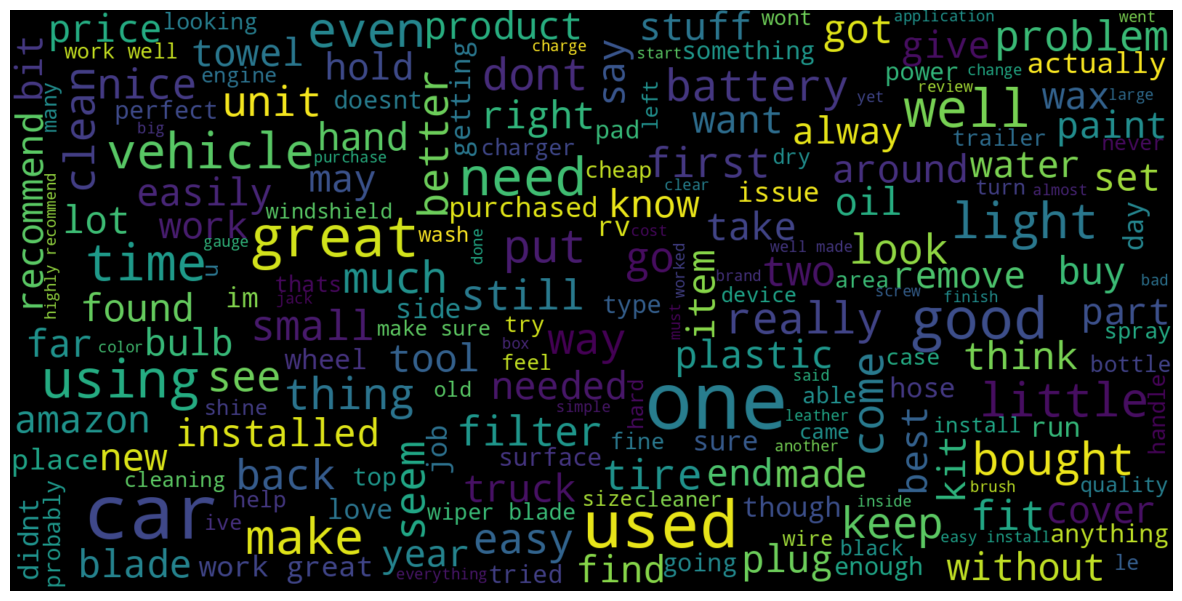

In [ ]:
consolidated=' '.join(word for word in reviews_w_sent['text_clean'].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.savefig('wordcloud.png')


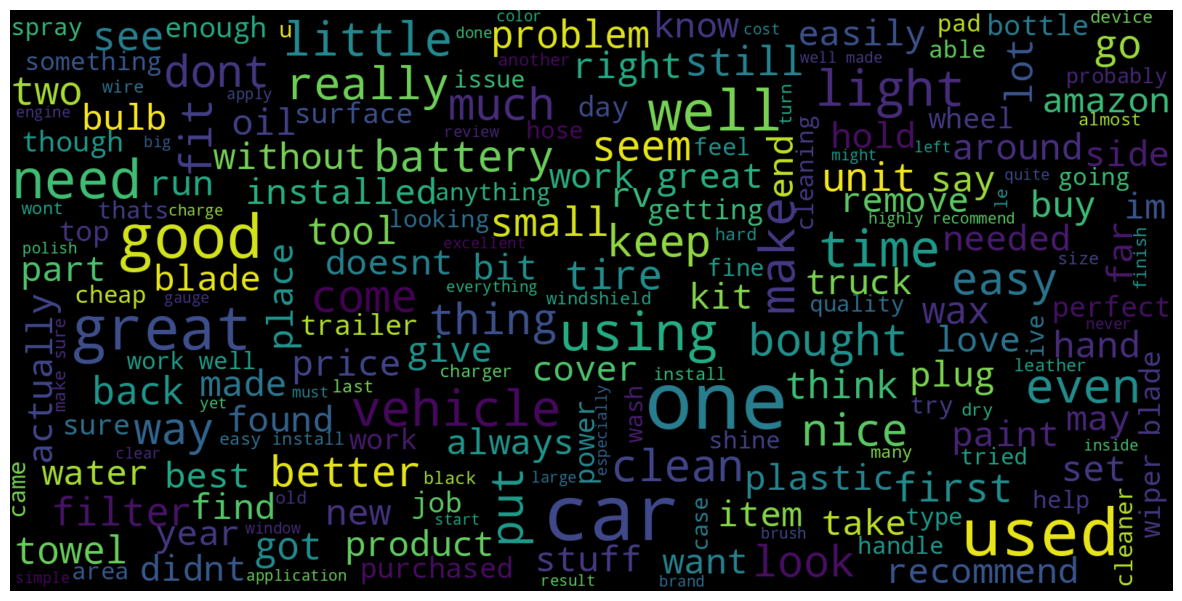

In [ ]:
consolidated=' '.join(word for word in reviews_w_sent['text_clean'][reviews_w_sent['sentiment']=='positive'].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

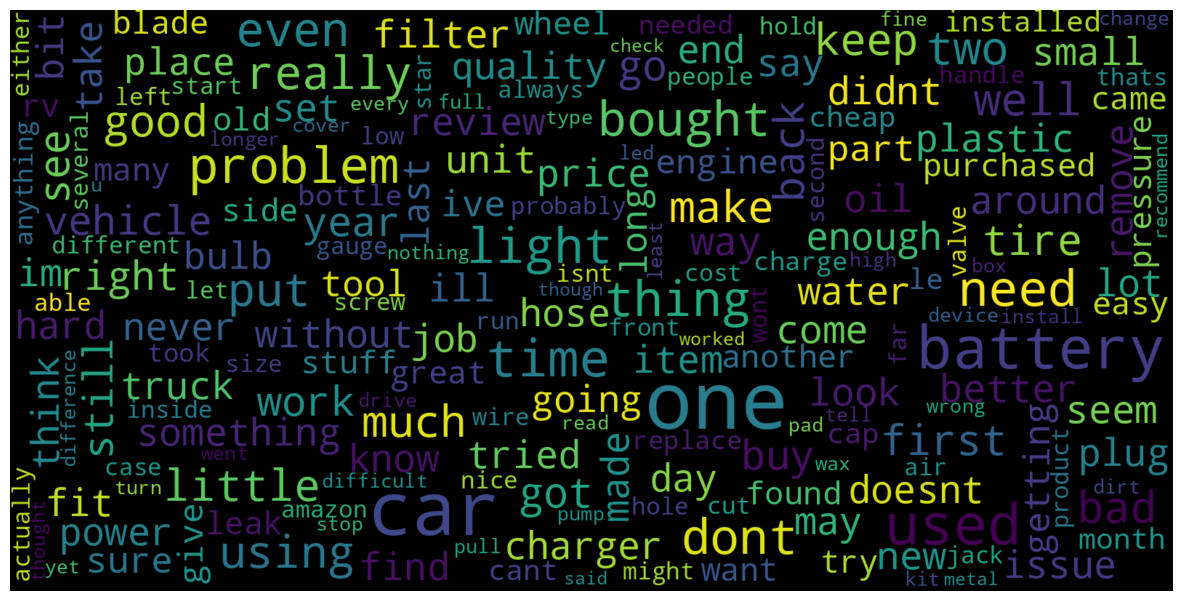

In [ ]:
consolidated=' '.join(word for word in reviews_w_sent['text_clean'][reviews_w_sent['sentiment']=='negative'].astype(str))
wordCloud=WordCloud(width=1600,height=800,random_state=21,max_font_size=110)
plt.figure(figsize=(15,10))
plt.imshow(wordCloud.generate(consolidated),interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
## review with the most neutral polarity

print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = reviews_w_sent.loc[reviews_w_sent.compound == 0, ['reviews']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

heavy duty chock and perform a expect these be also 12 cheaper than any store in my area sell the same product
this should take a lot of abuse get bang around in my recovery tool box on offroad adventure make fill tire back to street presure a snap easy to read
we use these for leveling role tire up onto stack and also for pad under leveling leg step and front tripod
i do remove the rod after every trip to drain the tank and i notice the rod always have a little more wear so i know it work can only imagine how much life it go to add to my h2 heater in my tt
i could not stand the smell of this i threw it out after have it in my car for 5 minute


In [ ]:
print(' 2 reviews with the most negative polarity: \n')
cl = reviews_w_sent.loc[reviews_w_sent.compound <= -0.97, ['reviews']].sample(2).values
for c in cl:
    print(c[0])



 2 reviews with the most negative polarity: 

for the money this be a nice block but not a heavy duty block i would say medium duty i use the block to lift v6 v8 engine on my haul trailer and it do fine another thing i want to add for people look at this block be the load limid which be 4k to 8k because when i be look this be not list and i be not sure if i want it or even if the block would have enough load limid for what i want to use it for i must say it be a nice block for around 8 and heavy built plenty for my use of lift engine around my yard and what ever else you want to use it for the block weighs about 4 to 5 pound more on the 4 pound range and can take up to 516 steel cable other than that the block have held up to everything i have thrown at it
you expect clone to be quality really whylet me list why they be poor1 hand solder and badly do in many case bad connection inside2 us a 5vdc power regulator chip that be not any good at all in car noisy environment nor do they add f

In [ ]:
!pip install cufflinks --upgrade

In [ ]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
len(reviews)

20453

In [ ]:
#polarity distribution
configure_plotly_browser_state()
reviews_w_sent['compound'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')


In [ ]:
#sentiment distrb
reviews_w_sent['sentiment'].iplot(
    kind='hist',
    xTitle='sentiment',
    linecolor='black',
    yTitle='count',
    title='Sentiment Distribution')

In [ ]:
reviews_w_sent['len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

In [ ]:
#distr word count
reviews_w_sent['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
#top unigram

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(reviews_w_sent['text_clean'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['text_clean' , 'count'])
df2.groupby('text_clean').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in preprocessed text')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



car 9165
like 5756
good 5735
great 5677
well 5646
used 4932
would 4785
time 4565
battery 3929
easy 3653
light 3625
make 3565
work 3556
much 3392
dont 3390
need 3338
really 3045
also 3035
fit 2979
using 2974


In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(reviews_w_sent['text_clean'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['text_clean' , 'count'])
df4.groupby('text_clean').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in preprocessed review')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



work great 815
wiper blade 696
work well 639
make sure 615
easy install 587
highly recommend 523
would recommend 511
well made 509
ive used 454
look like 421
much better 418
car wash 400
oil filter 383
battery tender 370
long time 356
last long 353
look great 336
oil change 324
microfiber towel 316
good quality 311


In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(reviews_w_sent['text_clean'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['text_clean' , 'count'])
df5.groupby('text_clean').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in preprocessed review')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



last long time 165
auto part store 121
check engine light 117
cant go wrong 91
would highly recommend 83
go long way 82
would recommend anyone 79
work really well 55
local auto part 54
look like new 53
ive ever used 49
worth every penny 48
look brand new 48
tire pressure gauge 48
little go long 47
well worth money 46
battery tender plus 42
seems well made 41
cabin air filter 40
get job done 39


In [ ]:
#review lenght by sentiment

y0 = reviews_w_sent.loc[reviews_w_sent['sentiment'] == 'positive']['len']
y1 = reviews_w_sent.loc[reviews_w_sent['sentiment'] == 'negative']['len']
y2 = reviews_w_sent.loc[reviews_w_sent['sentiment'] == 'neutral']['len']


trace0 = go.Box(
    y=y0,
    name = 'Positive',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'Negative',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Neutral',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)

data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Review length Boxplot of Sentiments"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Review Length Boxplot of Sentiments")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
len_bel_4000=reviews_w_sent[reviews_w_sent['len'] <=4000]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
#review lenght by sentiment

y0 = len_bel_4000.loc[len_bel_4000['sentiment'] == 'positive']['len']
y1 = len_bel_4000.loc[len_bel_4000['sentiment'] == 'negative']['len']
y2 = len_bel_4000.loc[len_bel_4000['sentiment'] == 'neutral']['len']


trace0 = go.Box(
    y=y0,
    name = 'Positive',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'Negative',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Neutral',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)

data = [trace0, trace1, trace2]
layout = go.Layout(
    title = "Review length Boxplot of Sentiments"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Review Length Boxplot of Sentiments")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
positive = reviews_w_sent[reviews_w_sent['sentiment'] == 'positive']
negative = reviews_w_sent[reviews_w_sent['sentiment'] == 'negative']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
#negative bigram
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(reviews_w_sent[reviews_w_sent['sentiment']=='negative']['text_clean'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['text_clean' , 'count'])
df4.groupby('text_clean').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in preprocessed negative review')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



dont know 48
wiper blade 35
im sure 33
battery tender 33
first time 32
engine light 31
oil filter 30
ive used 29
make sure 28
work well 28
dead battery 27
check engine 27
tire pressure 26
look like 25
heavy duty 24
well made 24
much better 24
last long 24
long time 23
pressure gauge 22


In [ ]:
#negative trigram
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(reviews_w_sent[reviews_w_sent['sentiment']=='negative']['text_clean'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['text_clean' , 'count'])
df5.groupby('text_clean').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in preprocessed negative review')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



check engine light 23
auto part store 12
get job done 11
bamboo cutting board 9
last long time 7
tire pressure gauge 7
lead acid battery 7
battery tender plus 6
total waste money 6
local auto part 5
power steering fluid 5
next time ill 5
accutire pressure gauge 5
work really well 4
buy new one 4
first time used 4
holding tank deodorizer 4
go long way 4
seems well made 4
really make difference 4


## LDA Analysis
Let’s apply the LDA model to find each document topic distribution and the high probability of word in each topic. Here, we want to specifically look at the negative reviews to find out what products have been critizized and had issues.


In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = lst_stopwords
stop_words.extend(['from', 'subject', 'get', 'one', 'use'])

def sent_to_words(sentences):
  for sentence in sentences:
    # deacc=True removes punctuations
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data = reviews_w_sent[reviews_w_sent['sentiment']=='negative']["reviews"].values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])


# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['absolutley', 'love', 'amazon', 'price', 'set', 'cheap', 'boosterjumper', 'cable', 'brick', 'morter', 'store', 'buy', 'extra', 'long', 'heavy', 'duty', 'jumper', 'first', 'dont', 'person', 'need', 'ask', 'kind', 'passerby', 'jump', 'also', 'jumper', 'cable', 'much', 'easy']
[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 8), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 14)]
['price', 'set', 'cheap', 'boosterjumper', 'cable', 'brick', 'morter', 'store', 'buy', 'extra', 'long', 'heavy_duty', 'jumper', 'first', 'person', 'need', 'ask', 'kind', 'passerby', 'jump', 'also', 'jumper_cable', 'much', 'easy', 'jump', 'start', 'let', 'talk', 'size', 'long']
[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 8), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21,

In [ ]:
def calculate_coherence_score(n, alpha, beta):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=alpha,
                                           per_word_topics=True,
                                           eta = beta)
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

#list containing various hyperparameters
no_of_topics = [2,5,7,10,12,14]
alpha_list = ['symmetric',0.3,0.5,0.7]
beta_list = ['auto',0.3,0.5,0.7]
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

for n in no_of_topics:
    for alpha in alpha_list:
        for beta in beta_list:
            coherence_score = calculate_coherence_score(n, alpha, beta)

            model_results['Topics'].append(n)
            model_results['Alpha'].append(alpha)
            model_results['Beta'].append(beta)
            model_results['Coherence'].append(coherence_score)


pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
model_results=pd.DataFrame(model_results)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
max = model_results[model_results['Coherence']==max(model_results['Coherence'])]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
max

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,Topics,Alpha,Beta,Coherence
91,14,0.5,0.7,0.513255


In [ ]:
# Let's compute the baseline coherence score
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Coherence Score:  0.4072740189445966


In [ ]:
model = gensim.models.LdaModel(corpus=corpus,
                               id2word=id2word,
                               num_topics=14,
                               passes=10,
                               alpha=0.5,
                               eta=0.7
                              )




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
import pyLDAvis.gensim
import pickle
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
num_topics=14
LDAvis_data_filepath = os.path.join(str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    pyLDAvis.save_html(LDAvis_prepared, str(num_topics) +'topic_neg_rev.html')

LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.136493 -0.039907       1        1  26.003586
10     0.111602 -0.034258       2        1  21.250713
9      0.100169  0.074793       3        1  20.038315
5      0.052249  0.007795       4        1   9.780007
13     0.032789  0.010380       5        1   7.917758
11    -0.040494  0.008077       6        1   2.316522
1     -0.038606 -0.004849       7        1   2.023578
6     -0.039469 -0.003875       8        1   2.012746
3     -0.045309  0.003595       9        1   1.610886
4     -0.054483 -0.003106      10        1   1.455034
7     -0.049341 -0.004297      11        1   1.442757
2     -0.059053 -0.006010      12        1   1.413542
8     -0.053162 -0.002840      13        1   1.370876
12    -0.053384 -0.005497      14        1   1.363679, topic_info=          Term        Freq       Total Category  logprob  loglift
14     battery  336.000000  336.000000  Default  30.0000  30.0000
114      light  212.000000  212.000000  Default  29.0000  29.0000
1211  pressure   92.000000   92.000000  Default  28.0000  28.0000
609      water   96.000000   96.000000  Default  27.0000  27.0000
454     filter  101.000000  101.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1154       gun    0.321871   36.687461  Topic14  -7.7885  -0.4411
109       last    0.349763  108.990882  Topic14  -7.7054  -1.4468
507      cover    0.330688   52.063962  Topic14  -7.7615  -0.7641
124       make    0.360512  267.084944  Topic14  -7.6751  -2.3128
421       time    0.319891  244.938981  Topic14  -7.7946  -2.3458

[835 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4907      1  0.189926  absorbent
4907      2  0.189926  absorbent
4907      3  0.189926  absorbent
4907      6  0.189926  absorbent
2312      1  0.051638   accurate
...     ...       ...        ...
3738      1  0.139799       zerk
3738      2  0.139799       zerk
3738      3  0.139799       zerk
3738      4  0.139799       zerk
3738      5  0.559195       zerk

[2697 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 11, 10, 6, 14, 12, 2, 7, 4, 5, 8, 3, 9, 13])

In [ ]:
#analyzing first 3 - battery, light, pressure, tire
neg=reviews_w_sent[reviews_w_sent['sentiment']=='negative']

clean = neg[neg.text_clean.str.contains('clean', regex=True)==True]
pump = neg[neg.text_clean.str.contains('pump', regex=True)==True]
leak = neg[neg.text_clean.str.contains('leak', regex=True)==True]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
!pip install keybert

In [ ]:
from keybert import KeyBERT
doc=' '.join(word for word in clean['reviews'].astype(str))
kw_model = KeyBERT()
kw_model.extract_keywords(doc, keyphrase_ngram_range=(3, 3), stop_words='english',
                              use_mmr=True, diversity=0.5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:193: RuntimeWarning:

invalid value encountered in matmul



[('jump jumper cable', 0.6646),
 ('shorter pull gauge', 0.3714),
 ('load amperageits car', 0.3712),
 ('way street booster', 0.3681),
 ('price size sufficient', 0.2)]

In [ ]:
docl=' '.join(word for word in leak['reviews'].astype(str))
kw_model.extract_keywords(docl, keyphrase_ngram_range=(3, 3), stop_words='english',
                              use_mmr=True, diversity=0.2)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:193: RuntimeWarning:

invalid value encountered in matmul



[('filter fram bad', 0.5894),
 ('bad filter risk', 0.5414),
 ('filter think defective', 0.5281),
 ('oil filter fail', 0.4996),
 ('smog year nowi', 0.4407)]

In [ ]:
docp=' '.join(word for word in pump['reviews'].astype(str))
kw_model = KeyBERT()
kw_model.extract_keywords(docp, keyphrase_ngram_range=(3, 3), stop_words='english',
                              use_mmr=True, diversity=0.2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:193: RuntimeWarning:

invalid value encountered in matmul



[('fuel filter ford', 0.7161),
 ('ford fuel line', 0.6212),
 ('filter ford vehicle', 0.5964),
 ('fuel line filter', 0.5863),
 ('3321 ford fuel', 0.5592)]